/var/folders/ty/cy038g3n0b76wc7182ktv28r0000gn/T/ipykernel_56239/2047451442.py:7: DtypeWarning: Columns (5,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')


Chi-square statistic: 8024.398586572438
P-value: 0.0


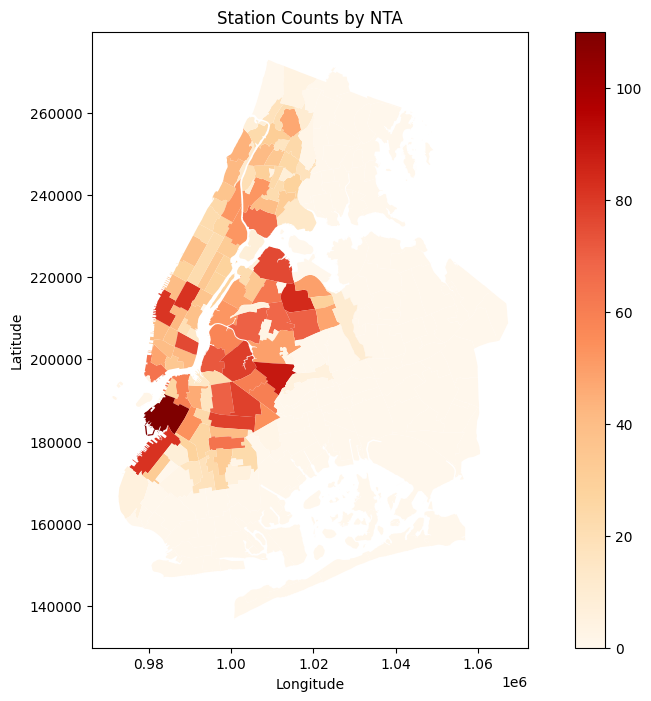

In [4]:
import pandas as pd
import geopandas as gpd
from scipy.stats import chisquare
import matplotlib.pyplot as plt

# Read data
data = pd.read_csv('./data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv')

# Get the geographical location of each station
station_locations = data.drop_duplicates('start_station_id')[['start_station_id', 'start_lat', 'start_lng']]

# Create GeoDataFrame for stations
gdf_stations = gpd.GeoDataFrame(
    station_locations, 
    geometry=gpd.points_from_xy(station_locations.start_lng, station_locations.start_lat),
    crs="EPSG:4326"
)

# Load NTA shapefile
nta_gdf = gpd.read_file('./nynta2020_24c/nynta2020.shp')

# Filter out Staten Island
nta_gdf = nta_gdf[nta_gdf['BoroName'] != 'Staten Island']

# Transform station data to the NTA coordinate system
gdf_stations = gdf_stations.to_crs(nta_gdf.crs)

# Spatial join to assign NTA to each station
stations_with_nta = gpd.sjoin(gdf_stations, nta_gdf, how='left', predicate='intersects')

# Count stations in each NTA
nta_station_counts = stations_with_nta.groupby('NTAName').size().reset_index(name='station_count')

# Merge with NTA GeoDataFrame
nta_gdf = nta_gdf.merge(nta_station_counts, on='NTAName', how='left')

# Fill NaN values with 0 for station counts
nta_gdf['station_count'] = nta_gdf['station_count'].fillna(0)

# Prepare observed and expected counts for chi-square test
observed_counts = nta_gdf['station_count'].values
total_stations = observed_counts.sum()
expected_counts = np.full_like(observed_counts, total_stations / len(observed_counts))

# Perform chi-square test
chi2_stat, p_value = chisquare(observed_counts, expected_counts)

print(f"Chi-square statistic: {chi2_stat}")
print(f"P-value: {p_value}")

# Plot the NTA with station counts
fig, ax = plt.subplots(figsize=(12, 8))
nta_gdf.plot(column='station_count', cmap='OrRd', legend=True, ax=ax)
plt.title('Station Counts by NTA')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.savefig('./map/station_counts_by_nta.png', dpi=300)
plt.show()


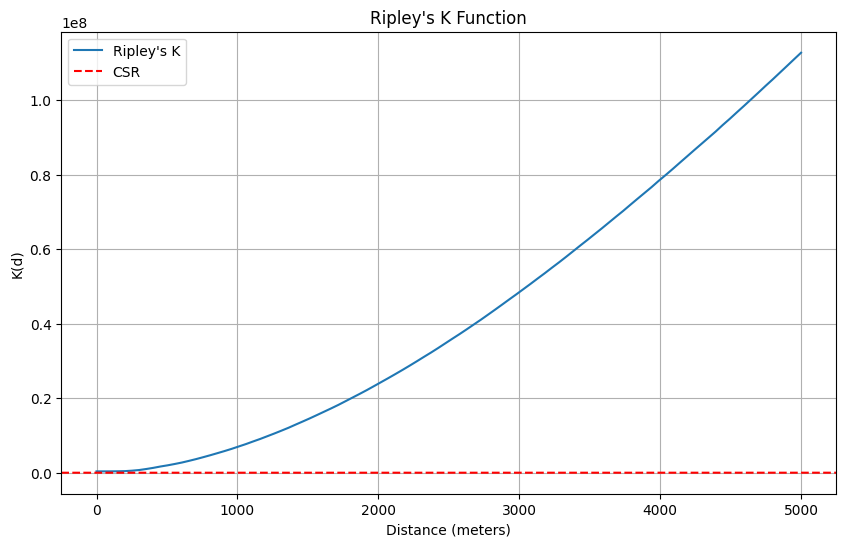

In [11]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from pointpats import PointPattern
from scipy.spatial import KDTree

# Read data
data = pd.read_csv(
    './data/202409-citibike-tripdata/202409-citibike-tripdata_1.csv',
    low_memory=False
)

# Get the geographical location of each station
station_locations = data.drop_duplicates('start_station_id')[['start_lat', 'start_lng']]

# Create GeoDataFrame for stations
gdf_stations = gpd.GeoDataFrame(
    station_locations, 
    geometry=gpd.points_from_xy(station_locations.start_lng, station_locations.start_lat),
    crs="EPSG:4326"
)

# Convert to a planar coordinate system for analysis
gdf_stations = gdf_stations.to_crs("EPSG:3857")

# Extract coordinates
coords = np.array([(point.x, point.y) for point in gdf_stations.geometry])

# Create PointPattern object
pp = PointPattern(coords)

# Define distances for K function
max_dist = 5000  # Maximum distance to consider
num_dists = 100  # Number of distance intervals
dists = np.linspace(0, max_dist, num_dists)

# Calculate Ripley's K function manually
def ripley_k(coords, dists):
    n = len(coords)
    area = pp.window.area
    k_values = np.zeros_like(dists)
    
    tree = KDTree(coords)
    
    for i, d in enumerate(dists):
        counts = [len(tree.query_ball_point(point, d)) for point in coords]
        k_values[i] = np.sum(counts) / n
    
    return (area / n) * k_values

k_values = ripley_k(coords, dists)

# Plot Ripley's K function
plt.figure(figsize=(10, 6))
plt.plot(dists, k_values, label="Ripley's K")
plt.xlabel('Distance (meters)')
plt.ylabel("K(d)")
plt.title("Ripley's K Function")
plt.axline((0, 0), slope=1, color='red', linestyle='--', label='CSR')
plt.legend()
plt.grid(True)
plt.savefig('./map/ripleys_k_function.png', dpi=300)
plt.show()
